In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lu_solve, lu_factor

%matplotlib widget

## Rosenbrock methods
The Newton iteration that is necessary for the implicit Euler or the Crank-Nicolson method can be computationally expensive, especially for larger systems. The Rosenbrock method is an attractive alternative to implicit methods based on Newton iteration that is specifically designed for stiff ODEs. The Rosenbrock method is an implicit one-step method and is derived from a backward differentiation formula (BDF) with additional corrections to achieve a specific order of accuracy.


#### General form
For a $s$-stage Rosenbrock method, the update formula for $\boldsymbol{y}_{n+1}$ is given by:
$$
\boldsymbol{y}_{n+1} = \boldsymbol{y}_n + h \sum_{i=1}^s b_i \boldsymbol{k}_i,
$$
where $\boldsymbol{k}_i$ are the stage values obtained as solutions of the linear equations:
$$
\left(I - \gamma h \mathsf{J}\right)\cdot \boldsymbol{k}_i = \boldsymbol{f}\Bigl(\boldsymbol{y}_n + h \sum_{j=1}^{i-1} a_{ij} \boldsymbol{k}_j\Bigr) + h \mathsf{J} \cdot\sum_{j=1}^{i-1} c_{ij} \boldsymbol{k}_j.
$$
Here $\boldsymbol{J}$ is the Jacobian matrix $\frac{\partial \boldsymbol{f}}{\partial \boldsymbol{y}}$ evaluated at $\boldsymbol{y}_n$, $h$ is the time step size, and $a_{ij}, b_i, c_{ij}, \gamma$ are method coefficients chosen to satisfy the desired order of accuracy. In order to obtain the stage values $\boldsymbol{k}_i$, one has to use a matrix solver to solve the linear equation. Since for all stages, the matrix $\left(I - \gamma h \boldsymbol{J}\right)$ is the same, it can be inverted (or better yet, LU decomposed) once and stored for all stages.

#### Third-Order Rosenbrock Method
For a third-order Rosenbrock method, three stages ($s=3$) are used. A commonly used linear-implicit method is the combination of a two-stage $y^{(2)}$ and three-stage $y^{(3)}$ Rosenbrock-Wanner method allowing for embedded error control. This method is known as `ODE23s` in MATLAB. The method is a good choice for stiff problems.  

The 2nd/3rd order update for $\boldsymbol{y}_{n+1}$ includes the weighted contributions of the stages:
$$
\begin{align*}
  \boldsymbol{y}^{(2)}_{n+1} &= \boldsymbol{y}_n + h \boldsymbol{k}_2,\\
\boldsymbol{y}^{(3)}_{n+1} &= \boldsymbol{y}_n + \frac{h}{6} \left(\boldsymbol{k}_1 + 4 \boldsymbol{k}_2 + \boldsymbol{k}_3\right).
\end{align*}
$$
which allows to estimate the error as
$$
\boldsymbol{\epsilon}_{n+1} = \boldsymbol{y}^{(3)}_{n+1} - \boldsymbol{y}^{(2)}_{n+1} = \frac{h}{6} \left(\boldsymbol{k}_1 - 2 \boldsymbol{k}_2 + \boldsymbol{k}_3\right).
$$
The update stages are computed as follows:
$$
\begin{align*}
k_1 &= (\mathsf{I}-\gamma h\mathsf{J}_n)^{-1}\;\cdot\boldsymbol{f}(\boldsymbol{y}_n) \\
k_2 &= (\mathsf{I}-\gamma h\mathsf{J}_n)^{-1}\;\cdot\left[\boldsymbol{f}(\boldsymbol{y}_n + h\boldsymbol{k}_1/2) -\gamma h\mathsf{J}\cdot k_1\right] \\
k_3 &= (\mathsf{I}-\gamma h\mathsf{J}_n)^{-1}\;\cdot\left[\boldsymbol{f}(\boldsymbol{y}_n + h\boldsymbol{k}_2) -d_{31} h\mathsf{J}\cdot k_1 -d_{32}   h\mathsf{J}\cdot  k_2\right]
\end{align*}
$$
where
$$
\begin{align*}
\mathsf{J}_n := D\boldsymbol{f}(\boldsymbol{y}_n) \quad  \gamma:=\frac{1}{2+\sqrt{2}}, \quad d_{31} = -\frac{4+\sqrt{2}}{2+\sqrt{2}}, \quad d_{32} = \frac{6+\sqrt{2}}{2+\sqrt{2}}
\end{align*}
$$

In [2]:
def rosenbrock32_step(f, Df, yi, h):
  """
  Solve an ODE y' = f(y) using a 3rd-order implicit Rosenbrock method.

  Parameters:
      f:              The right-hand side of the ODE, f(y).
      Df:             The Jacobian of f(y): Df(y).
      yi:             The initial condition for the step
      h:              The step size.
  Returns:
    (y_next, error):  where y_next is the solution at the next time step and
                      error is the estimated error.
  """

  # Parameters for 3rd-order Rosenbrock method
  sqrt2 = np.sqrt(2)
  gamma  = 1/(2 + sqrt2)
  d31 = - (4 + sqrt2) / (2 + sqrt2)
  d32 = (6 + sqrt2) / (2 + sqrt2)
  
  # linear inverse
  I  = np.eye(len(yi))
  J  = Df( yi )
  A  = I - gamma * h * J
  LU_and_piv = lu_factor(A, overwrite_a=True)

  # Stage 1
  b1 = f( yi )
  k1 = lu_solve( LU_and_piv, b1 )
  # Stage 2
  hJk1 = h * J@k1
  b2 = f( yi + 0.5 * h * k1 )  - gamma * hJk1
  k2 = lu_solve( LU_and_piv, b2 )
  # Stage 3
  hJk2 = h * J@k2
  b3 = f( yi + h * k2 ) - d31 * hJk1 - d32 * hJk2
  k3 = lu_solve( LU_and_piv, b3 )
  # Advance solution
  y_next = yi + h/6 * (k1 + 4*k2 + k3)
  error  = h/6 * (k1 - 2*k2 + k3)
  
  return y_next, error

### Adaptive step sizes with embedded error control
The error estimate can be used to adjust the time step size $h$ in the next iteration. The time step size can be adjusted by a factor $\alpha$ such that the error estimate is within a desired tolerance $\text{tol}$:
\begin{align*}
h_{\text{new}} = h \left(\frac{\text{tol}}{\|\vec{\epsilon}_{n+1}\|}\right)^{1/3}.
\end{align*}
This adaptive step size control can be relatively easily implemented similarly to the approach we have taken for the Gragg-Burlisch-Stoer method

In [3]:
def rosenbrock32( f, Df, x0, y0, x_end, h_first = 0.1, reltol = 1e-6, abstol = 1e-6, max_steps = 10000 ):
    """
    Solves an IVP using the Bulirsch-Stoer method for high-accuracy solutions.

    Parameters:
        f:            Callable for system dynamics, dy/dx = f(x, y).
        Df:           Callable for Jacobian of system dynamics.
        x0:           Initial x value.
        y0:           Initial y value.
        x_end:        Final x value.
        h_first:      Initial step size.
        tol: Error    tolerance.
        n_refine_max: Maximum number of refinements.
        max_steps:    Maximum number of steps.

    Returns:
        x_vals:       Array of x values.
        y_vals:       Array of y values.
        err_vals:     Array of error estimates.
    """
    x_vals, y_vals, err_vals = np.array(x0), np.array([y0]), 0.*np.array([y0])
    x, h, num_steps = x0, h_first, 0

    while x < x_end:
        h = min(h, (x_end - x)+np.finfo(float).eps )
        num_steps += 1
        yF, error = rosenbrock32_step(f, Df, y_vals[-1], h)
        converged = np.linalg.norm(error) < np.minimum(reltol * np.linalg.norm(yF), abstol)

        if converged:
          x        = x + h
          x_vals   = np.append( x_vals, x )
          y_vals   = np.vstack( (y_vals, yF) )
          err_vals = np.vstack( (err_vals, error) )
          # Increase step size
          h *= min(5.0, 0.9 * (reltol / np.linalg.norm(error))**(1. / 3))
        else:
          # Reduce step size
          h *= 0.9 * (reltol / np.linalg.norm(error))**(1. / 3)

        if num_steps > max_steps:
          raise RuntimeError("Maximum number of steps exceeded.")
            
    return x_vals, y_vals, err_vals

In [6]:
# Example: van der pol oscillator
mu = 20
def f_vanderpol(y):
    return np.array([y[1], mu*(1-y[0]**2)*y[1]-y[0]])

def df_vanderpol(y):
    return np.array([[0, 1], [-2*mu*y[0]*y[1]-1, mu*(1-y[0]**2)]])

x0, x_end = 0, 100
y0 = [2.0,0.0]

# Solve using rosenbrock32
tol = 1e-4
t_vals_ro32, y_vals_ro32, err_vals_ro32 = rosenbrock32(f_vanderpol, df_vanderpol, x0, y0, x_end, reltol=tol, abstol=tol) 
print(f"Rosenbrock32: Number of steps = {len(t_vals_ro32)} to achieve tolerance = {tol}")

Rosenbrock32: Number of steps = 1062 to achieve tolerance = 0.0001


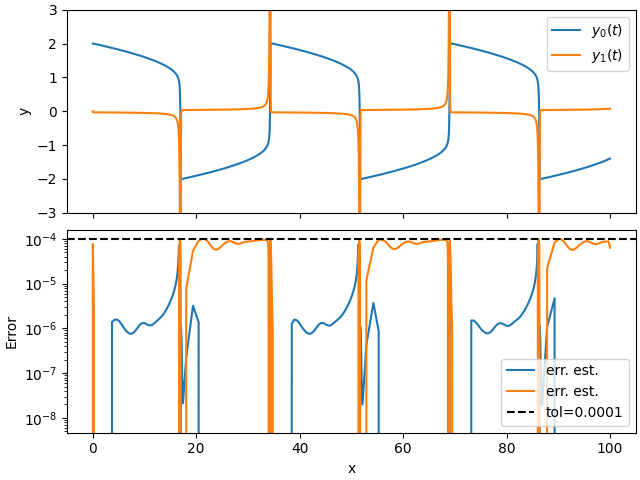

In [7]:
fig, ax = plt.subplots(2, 1,sharex=True, layout='constrained')
ax[0].plot(t_vals_ro32, y_vals_ro32[:, 0], '-', label='$y_0(t)$')
ax[0].plot(t_vals_ro32, y_vals_ro32[:, 1], '-', label='$y_1(t)$')
ax[0].set_ylim(-3,3)
ax[0].set_ylabel('y')
ax[0].legend()

ax[1].plot(t_vals_ro32, err_vals_ro32, '-', label='err. est.')
ax[1].axhline(tol, color='k', linestyle='--', label='tol={}'.format(tol))
ax[1].set_yscale('log')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Error')
ax[1].legend()